# Detección de fraude
---
Esta parte de la evaluación consiste en realizar un modelo de predicción de fraude.

El set de datos està en `data/fraud/creditcard_train.csv`

La evaluación es tipo *datathon* de forma que las notas se calcularán en base a:

1. Al ranking de métricas de los modelos (80%)
2. Legibilidad y presentación del código (20%)

La forma de entrega será generar un fichero csv en formato a partir de las predicciones realizadas sobre el fichero `data/fraud/creditcard_test.csv`.

| IdObservación | clase_predicha | probabilidad_clase_1 |
| ------------- | ------------- | ------------- |
|00001|True|0.6398|
|00002|True|0.5892|
|00003|False|0.2163|

EL fichero resultante tiene que tener por nombre `inicialapellido_test.csv` y se tiene que enviar por email a:

datathonuib@gmail.com

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis descriptivo básico

### Preparación de los datos

In [2]:
df_train = pd.read_csv('data/fraud/creditcard_train.csv')

In [7]:
df_train.head(5)

,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,44.0,-0.948896,0.248414,2.956914,2.813750,0.145539,-0.027353,0.133702,-0.307535,...,-0.083647,0.416090,0.207537,0.716064,-0.602311,-0.064230,-0.315058,-0.272463,0.75,0
1,1,56.0,0.086996,-0.051989,-0.497882,-3.151908,2.558400,2.796671,0.470283,0.265333,...,-0.239426,-0.437342,0.018426,1.013038,-0.258927,-0.293189,-0.394956,-0.435996,10.84,0
2,2,125.0,-0.724910,0.073475,1.739547,0.758588,0.229543,2.422069,0.196688,0.861076,...,0.188696,0.738515,0.145933,-1.032186,-0.087511,-0.221063,0.108168,0.011785,113.00,0
3,3,140.0,1.175478,0.167881,0.509909,0.452332,-0.215763,-0.192104,-0.105404,0.068517,...,-0.176147,-0.500566,0.151263,0.018347,0.122003,0.106307,-0.014937,0.005771,1.29,0
4,4,196.0,1.198658,-0.420334,0.014599,-0.270793,-0.471074,-0.384610,-0.083890,-0.077570,...,-0.630206,-1.504432,0.193771,-0.017458,0.058387,0.145373,-0.034904,0.011037,63.90,0


Eliminamos la columna **Index** pues no ofrece información, además ya la estructura de data frame de **Pandas** ya proporciona dicha información.

In [15]:
df_train = df_train[df_train.columns[1:]]

### Estadísticos básicos del conjunto de datos

In [6]:
df_train.describe()

,index,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,...,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000,8274.000000
mean,4136.500000,94413.335630,-0.192386,0.164128,-0.320883,0.214420,-0.138538,-0.045972,-0.260026,0.020558,...,0.036519,-0.010749,0.005431,-0.010122,0.011992,0.008631,0.010403,0.002055,89.591424,0.047619
std,2388.642397,47090.203021,2.539145,1.976724,2.536887,1.758363,1.861499,1.380380,2.269845,1.890984,...,1.134010,0.786006,0.601718,0.598658,0.521701,0.487096,0.471975,0.311344,239.425840,0.212972
min,0.000000,44.000000,-30.552380,-34.575064,-31.103685,-5.020488,-25.025820,-9.847370,-43.557242,-41.044261,...,-22.797604,-8.887017,-15.981649,-2.766638,-3.536716,-1.480189,-7.263482,-5.706918,0.000000,0.000000
25%,2068.250000,54238.500000,-0.989676,-0.583268,-1.090674,-0.780131,-0.749119,-0.803048,-0.623201,-0.201921,...,-0.231617,-0.550772,-0.163394,-0.362282,-0.311030,-0.321798,-0.068158,-0.054186,5.000000,0.000000
50%,4136.500000,84863.500000,-0.023586,0.114158,0.106146,0.063112,-0.070332,-0.292343,0.011035,0.032206,...,-0.022282,0.001268,-0.011584,0.031144,0.031149,-0.044219,0.005249,0.013256,21.230000,0.000000
75%,6204.750000,138697.500000,1.297560,0.888651,0.974192,0.882648,0.598011,0.408838,0.550909,0.358243,...,0.206964,0.521199,0.145209,0.422574,0.358695,0.264279,0.108512,0.084301,78.900000,0.000000
max,8273.000000,172786.000000,2.371289,22.057729,4.187811,12.114672,16.625394,14.570654,26.237722,20.007208,...,27.202839,8.361985,17.606637,3.633399,3.410742,2.807408,4.347262,9.641075,7541.700000,1.000000


En la tabla anterior, tenemos información como la media, la desviación típica, el valor mínimo, máximo y los cuartiles para tener una primera aproximación sobre los datos que se van a manejar.

### Mapa de calor de correlaciones

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,0.132767,-0.051493,-0.179169,-0.117580,0.180714,-0.042172,0.104102,-0.058180,0.041697,...,0.003443,0.152672,0.045358,-0.021328,-0.235903,-0.022807,-0.030382,-0.012999,-0.007215,-0.057326
V1,0.132767,1.000000,-0.389514,0.499487,-0.312270,0.427390,0.094755,0.560628,-0.017047,0.328995,...,-0.035040,-0.012874,-0.108347,0.002495,-0.021630,0.005615,0.092833,0.087338,-0.160490,-0.404000
V2,-0.051493,-0.389514,1.000000,-0.466346,0.313926,-0.379482,-0.070980,-0.458329,-0.063384,-0.258798,...,0.009483,0.021636,-0.006299,0.011611,-0.000638,-0.010501,-0.063979,0.104063,-0.426942,0.387193
V3,-0.179169,0.499487,-0.466346,1.000000,-0.448197,0.503468,0.178019,0.658837,-0.073449,0.428935,...,-0.018605,-0.047431,-0.071009,0.014950,-0.024132,-0.009424,0.077817,0.030060,-0.108428,-0.585672
V4,-0.117580,-0.312270,0.313926,-0.448197,1.000000,-0.308637,-0.122839,-0.438849,0.052862,-0.358999,...,0.024326,0.054710,0.050562,-0.028337,0.007073,0.035142,-0.011936,-0.047086,0.074212,0.544192
V5,0.180714,0.427390,-0.379482,0.503468,-0.308637,1.000000,0.124176,0.548437,-0.078417,0.315374,...,-0.006452,-0.044130,-0.069892,-0.021255,-0.018902,0.013767,0.112871,0.025821,-0.282037,-0.359254
V6,-0.042172,0.094755,-0.070980,0.178019,-0.122839,0.124176,1.000000,0.104787,-0.175296,0.129780,...,0.019543,-0.021577,0.067084,0.011454,-0.016115,-0.010276,-0.046364,0.011048,0.200226,-0.210472
V7,0.104102,0.560628,-0.458329,0.658837,-0.438849,0.548437,0.104787,1.000000,0.099865,0.423282,...,0.012166,-0.074201,-0.080967,-0.006908,0.014400,0.000851,0.147975,0.050673,0.210899,-0.525895
V8,-0.058180,-0.017047,-0.063384,-0.073449,0.052862,-0.078417,-0.175296,0.099865,1.000000,-0.034500,...,-0.085442,0.013296,-0.230797,0.008381,0.066563,0.025638,0.181944,-0.012848,-0.034314,0.044723
V9,0.041697,0.328995,-0.258798,0.428935,-0.358999,0.315374,0.129780,0.423282,-0.034500,1.000000,...,0.065118,-0.067549,-0.038184,0.013181,-0.001475,-0.013897,0.066719,0.032622,-0.052711,-0.425832


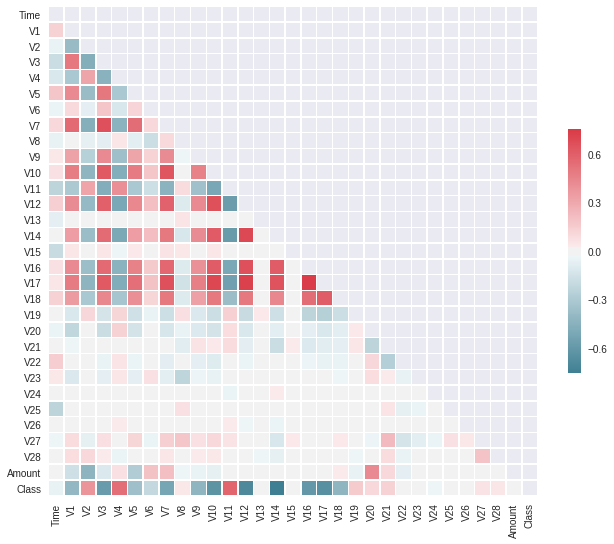

In [16]:
# Getting and showing correlation matrix
corr = df_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

corr

Como podemos observar del mapa de calor anterior, no existen correlaciones demasiado elevadas entre las variables. De hecho, hay una gran parte de variables que tienen una correlación practicamente nula. 
Debido a ello, no tendría sentido aplicar **Análisis de componentes principales (PCA)** para reducir la dimensionalidad, en este caso de 31 variables.

# Modelización de los datos

En este punto, utilizaremos una serie de modelos estadísticos donde a la postre los compararemos mediante una serie de métricas tales como **AUC** o **ROC** que nos permitirán escoger el mejor modelo.

Debido a que disponemos un conjunto de datos de prueba que no contiene el valor real de la variable respuesta, utilizaremos el conjunto de entrenamiento para realizar las pruebas en primera instancia y obtener una aproximación del error.

Una vez elegido el mejor modelo, utilizaremos el conjunto de prueba real sobre el que deseamos realizar la predicción.

Los modelos elegidos son:

* Regresión logística
* Random Forest
* Boosting

### Regresión Logística

In [6]:
## Cargamos los datos de vinos
import pandas as pd

df = df_train

# importa el modulo de regresión logística
from sklearn.linear_model import LogisticRegression

# importa el modulo de StratifiedKfold
from sklearn.model_selection import StratifiedKFold

# importa el modulo de cross_val_predict
from sklearn.model_selection import cross_val_predict

#importa el modulo necesario para realizar la partición entre train y test
from sklearn.model_selection import train_test_split

# divide el dataset en train y test con un tamaño de test del 20% de los datos
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df.Class, test_size=0.1, random_state=1234)

# usa el StratifiedKFold para dividir el X_train en 5 partes. Usa el random_state = 1234
kfold = StratifiedKFold(n_splits=30, random_state=1234)

# instancia una regresión logistica
clf = LogisticRegression()

# usa la función de cross_val_predict para entrenar y evaluar la regresión logística usando el StratifiedKFold
y_pred = cross_val_predict(clf, X_train, y_train, cv=kfold)

In [7]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train, y_pred, labels=[1, 0]))

[[ 272   81]
 [   4 7089]]


In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(y_train, y_pred))
print("Precision:", precision_score(y_train, y_pred))
print("Recall:", recall_score(y_train, y_pred))
print("F1:", f1_score(y_train, y_pred))

Accuracy: 0.988584474886
Precision: 0.985507246377
Recall: 0.770538243626
F1: 0.864864864865


In [9]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      7093
          1       0.99      0.77      0.86       353

avg / total       0.99      0.99      0.99      7446



In [11]:
# vamos a predecir las probabilidades del ejercicio anterior
y_proba = cross_val_predict(clf, X_train, y_train, cv=kfold, method='predict_proba')

[]

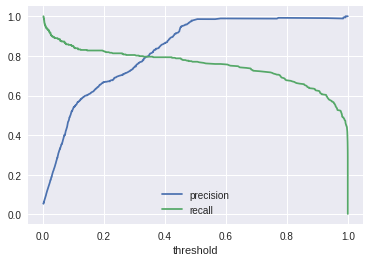

In [12]:
# importa el metodo que nos permite encontrar la curva de precisión y recall
from sklearn.metrics import precision_recall_curve

# calcula la precision, el recall y los umbrales
prec, rec, thre = precision_recall_curve(y_true=y_train, probas_pred=y_proba[:,1])

# haz un plot de la precision y el recall en función de los umbrales
plt.plot(thre, prec[:-1], label='precision')
plt.plot(thre, rec[:-1], label='recall')
plt.legend(loc='best')
plt.xlabel('threshold')
plt.plot()

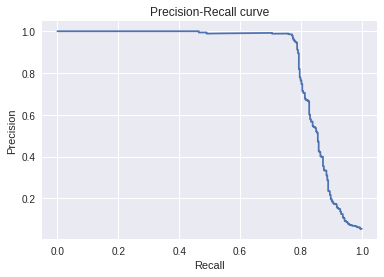

In [13]:
# plotea la precisión en funcion del recall
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')

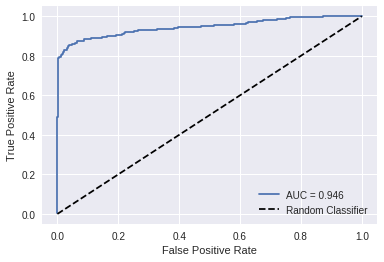

In [14]:
## Repite el ejercicio anterior pero con la curva ROC
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thre = roc_curve(y_train, y_proba[:,1])
roc_auc = roc_auc_score(y_train, y_proba[:, 1])

plt.plot(fpr, tpr, label='AUC = {a}'.format(a=round(roc_auc, 3)))
plt.plot([0, 1], '--', c='black', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

In [ ]:
Prueba